In [1]:
%ls ../input
%ls ../input/synimg/synimg/train/Beijing | head -5


synimg/
train-Beijing-1050000.jpg
train-Beijing-1050001.jpg
train-Beijing-1050002.jpg
train-Beijing-1050003.jpg
train-Beijing-1050004.jpg


In [37]:

import skimage.io as io
import os
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("../src")  # This is relative to test directory e.g. /realestatereview/test
from data import read_data_from_file, get_labels



In [3]:
WIDTH = 64
HEIGHT = 32
ROOT_PATH = '../input/synimg/'

In [11]:
def read_data_from_file(filename, nrows=None, max_per_class=None):
    '''
        File is in the format of data.csv or data_nostyle.csv,
        containing location of each image and IDs and/or la
        filename example: 'synimg/test/data_nostyle.csv'
    '''
    data = pd.read_csv(ROOT_PATH + filename, nrows=nrows)
    if max_per_class:
        data = data.groupby('style_name').head(max_per_class).reset_index()
    # print("Shape and review after getting max per group:\n", data.shape, "\n", data.head(20))
    # data = data.sample(frac=1.0) 
    # Read images
    all_images = read_images(data, max_per_class) # includes caching

    return data, all_images


def read_images(data, max_per_class):
    all_images = []
    for idx, row in data.iterrows():
        img = io.imread(ROOT_PATH + row['filepath'])
        all_images.append(img)
    return all_images

# Objectives of this setting up / exploratory script:
* Setup all environments (libraries/ dependencies. Folder structure to be compatible with Kaggle kernel)
* Doing basic input/output. Output that is compatible with submission format
* Some basic utility functions:
    * show image
    * image to binary array data
    * binary data back to image data
    * some dumb features transformation
* Dummy model
* Dummy model but makes use of some image data
* Dummy CNN model but include some troubleshooting and/or training/testing 

# Step 1: Doing input/output

In [26]:
MAX_PER_CLASS=500
train_data, train_images =  read_data_from_file('synimg/train/data.csv', max_per_class=MAX_PER_CLASS)
test_data, test_images = read_data_from_file('synimg/test/data_nostyle.csv')
label_encoder, train_data = get_labels(train_data, print_classes=False) # one-hot encode, returns in column 'style_id'

print(train_data.head(1))
train_data.shape


(5000, 6)

## let's try to see an image

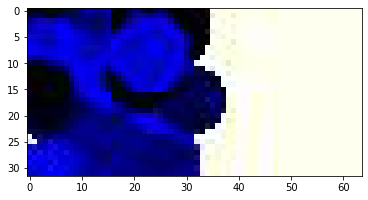

In [13]:
plt.imshow(train_images[0])

## Features

This submission explores 1 single idea. It looks like the shapes (circles) are standardised in sizes, and only vary in colours and positions (how they scatter). Perhaps a proxy for positions of circles are the area of white (i.e. the unoccupied area). If we simply produce a histogram of colours, it can be a baseline solution.

Some other observations
* Even with colours it's not map to standard colours, but looks like it has continuous ranges (e.g. white and near-white). Perhaps even got an alpha channel blended in
* Simple ideas is to standaridise it, to make colours a discriminative features. Let's just exploit this as a unique single feature
* So (252, 253, 255) should be mapped to (255, 255, 255)

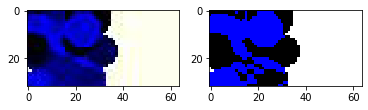

In [14]:
from features import convert_nearest_std_colors
def show_before_after(image):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    image, hist = convert_nearest_std_colors(image)
    axarr[1].imshow(image)
#     plt.show()    

show_before_after(train_images[0])

### Another example

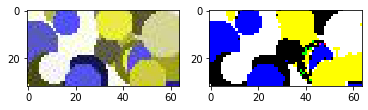

In [36]:
show_before_after(train_images[1000])

# Preprocess features


In [27]:
# Preprocess features
from features import extract_features
X_train = extract_features(train_images, cachefile='../cache/train_500')
y_train = list(train_data['style_id'])

Extract features starting...
loaded from cache


# Model selection

Evaluate a bunch of model in this baseline features

In [28]:
from model import model_selection
model = model_selection(X_train, y_train)  # return a trained model that implements predict()from a bunch of candidates model


X_train, y_train:  5000 5000
LOG :  0.621
RAN :  0.6303333333333333
GRA :  0.6053333333333333


#Predict and write output for submission

In [29]:
X_test = extract_features(test_images, cachefile='../cache/test')
test_data['label_id'] = model.predict(X_test)


Extract features starting...
loaded from cache


Counter({'Geneva': 2921, 'Beijing': 2612, 'HongKong': 2324, 'Melbourne': 2275, 'Singapore': 2075, 'Zurich': 2016, 'Seoul': 2013, 'Luanda': 2001, 'Sydney': 1174, 'Brisbane': 589})


<BarContainer object of 10 artists>

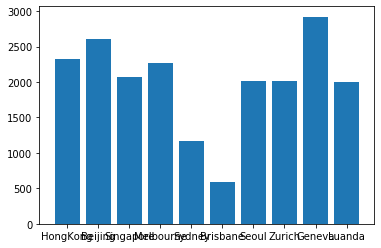

In [35]:
def write_output(test_data, label_encoder):
    test_data['style_name'] = label_encoder.inverse_transform(test_data['label_id'])
    # Doing some validation
    from collections import Counter
    counter = Counter(test_data['style_name'])
    print(counter)
    test_data[['id', 'style_name']].to_csv('../submit.csv', index=False)
    return test_data, counter

test_data, counter = write_output(test_data, label_encoder)
plt.bar(counter.keys(), counter.values())

In [ ]:
test_data[['id', 'style_name']].to_csv('../submit.csv', index=False)

# TODO: 
* diagnosing model fit - looks like model training does not convert. Not enough variance in training data or not enough iterations?
* hyper params tuning
* diagnose confusino matrix - which classes tend to fail the most and why? 